### The purpose of this is to go over a function to grid search SARIMA parameters and output a fitted model with those parameters. I am skipping differencing, Dickey Fuller tests, and plotting ACF and PACF. If this were a comprehensive SARIMA demo, those things would be included.

#### First, I start with my imports and dataset loading.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
import itertools
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

dataset = pd.read_csv('passengers.csv')

#### Then, I take a look at my first few rows along with the shape.

In [2]:
dataset.head()

,Month,Passengers
0,1/1/1949,112
1,2/1/1949,118
2,3/1/1949,132
3,4/1/1949,129
4,5/1/1949,121


In [3]:
dataset.shape

(144, 2)

#### The next step is to make the month column the index.

In [4]:
dataset['Month'] = pd.to_datetime(dataset['Month'])
dataset.set_index('Month', inplace=True)
dataset.index.freq = 'MS'

In [5]:
dataset.head()

,Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


#### A quick plot visualizes what we are working with.

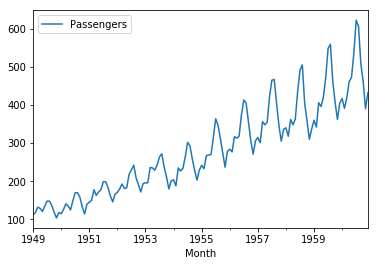

In [6]:
dataset.plot()

#### The data gets broken up into training and test, the test making up about the last year.

In [7]:
train, test = dataset.iloc[:131], dataset.iloc[131:]

#### And here is the function. It takes two parameters, a dataset and an eval metric (aic or bic). This first part loops though all the variations of parameters (for order and seasonal_order), and collects that into a dictionary. The second part finds the best model from the dictionary and then fits a model to it. The output is a dictionary with the model, aic, bic, order tuple and seasonal_order tuple.

In [8]:
def find_best_sarima(train, eval_metric):
    
    p = d = q = range(0, 2)
    pdq = list(itertools.product(p, d, q))
    seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

    counter = 0
    myDict = {}
    
    for param in pdq:
        for param_seasonal in seasonal_pdq:
            try:
                counter += 1
                mod = sm.tsa.statespace.SARIMAX(train,
                                                order=param,
                                                seasonal_order=param_seasonal,
                                                enforce_stationarity=False,
                                                enforce_invertibility=False)

                results = mod.fit()
                myDict[counter] = [results.aic, results.bic, param, param_seasonal]

            except:
                continue
                
    dict_to_df = pd.DataFrame.from_dict(myDict,orient='index')
    
    if eval_metric == 'aic':
        best_run = dict_to_df[dict_to_df[0] == dict_to_df[0].min()].index.values
        best_run = best_run[0]
    elif eval_metric == 'bic':
        best_run = dict_to_df[dict_to_df[1] == dict_to_df[1].min()].index.values
        best_run = best_run[0]
            
    model = sm.tsa.statespace.SARIMAX(train,
                                      order=myDict[best_run][2],
                                      seasonal_order=myDict[best_run][3],
                                      enforce_stationarity=False,
                                      enforce_invertibility=False).fit()
    
    best_model = {'model':model, 
                  'aic':model.aic,
                  'bic':model.bic,
                  'order':myDict[best_run][2], 
                  'seasonal_order':myDict[best_run][3]}
    
    return best_model

#### The called function is put into a parameter.

In [9]:
best = find_best_sarima(train, 'aic')

#### Here we can see the the items of the best dictionary.

In [10]:
best

{'model': <statsmodels.tsa.statespace.sarimax.SARIMAXResultsWrapper at 0x228061c6208>,
 'aic': 793.9172538749733,
 'bic': 804.4948174715388,
 'order': (0, 1, 1),
 'seasonal_order': (1, 1, 1, 12)}

#### Finally, we put the prediction into a variable using the model from the best dictionary.

In [11]:
pred = best['model'].predict(start=test.index[0], end=test.index[-1], dynamic=True)

#### The prediction is then plotted with the actuals.

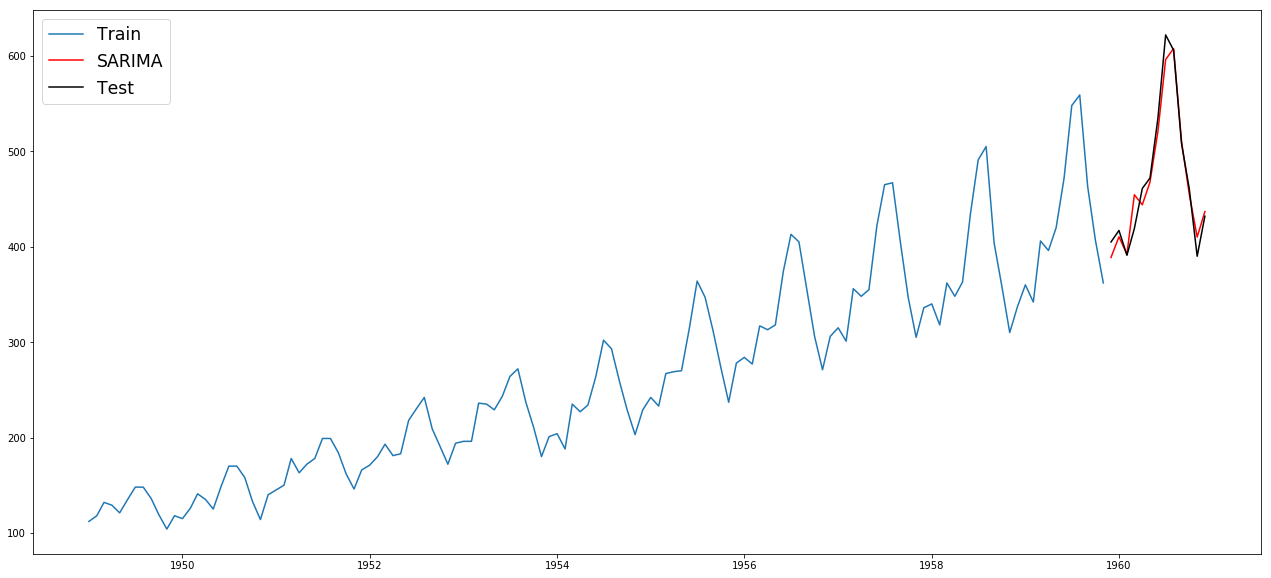

In [12]:
plt.figure(figsize=(22, 10))
plt.plot(train.index, train, label='Train')
plt.plot(pred.index, pred, label='SARIMA', color='r')
plt.plot(test.index, test, label='Test', color='k')
plt.legend(loc='best', fontsize='xx-large')
plt.show()

#### To cap this off, I want to run the loop that found the best parameters, but this time, it will just print out the results. From this we can verify what our function chose.

In [13]:
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(train,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            results = mod.fit()
            
            print('ARIMA{}x{}12 - AIC:{} - BIC:{}'.format(param, 
                                                          param_seasonal, 
                                                          results.aic, 
                                                          results.bic))

        except:
            continue


ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:1838.694130139263 - BIC:1841.5616645897187
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:1560.955838509434 - BIC:1566.4972077583652
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:1170.9691478093239 - BIC:1173.7398324337896
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:1024.839836529251 - BIC:1030.1667147174753
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:1007.4849329176894 - BIC:1013.0431799039125
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:999.0294206170553 - BIC:1007.3414744904522
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:983.0835102230483 - BIC:988.429167891972
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:918.1507784719358 - BIC:926.141095754272
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:1656.152365783345 - BIC:1661.8719905920684
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:1396.5335790324286 - BIC:1404.820100836822
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:1061.5955125134249 - BIC:1067.1198603830203
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:943.5041271721606 - BIC:951.4660082226331
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:1011.